In [1]:
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN

import time
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit import QuantumRegister,ClassicalRegister
from IPython.display import clear_output

from scipy.special import rel_entr
import pickle

In [3]:
# A function that evaluates the bitstring, all 0 bitstring gets mapped to 0 
def countZero(x):
    out=f"{bin(x)}".count("1")
    if out==0:
        return 0
    else:
        return 1

def make_ansatz(qc_ansatz,num_layers,num_qubits,weights):
    params_index = 0 #index counter
    for layer in range(num_layers):
              
        for i in range(num_qubits):
            qc_ansatz.rx(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits):
            qc_ansatz.ry(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits):
            qc_ansatz.rz(weights[params_index],i)
            params_index += 1
            
        for i in range(num_qubits-1):
            qc_ansatz.cy(i,i+1)
               
    return qc_ansatz

#A function that gives the Unitary of some ansatz.
def make_ansatz_unitary(num_layers,num_qubits,params):
    qr = QuantumRegister(num_qubits,'qr') #quantum register
    cr = ClassicalRegister(num_qubits,'cr') #classical register
    qc = QuantumCircuit(qr,cr) #construct ansatz
    qc=make_ansatz(qc,num_layers,num_qubits,params)
    qc.draw('mpl')
    return qi.Operator(qc)

#Create the sampler that computes the HS cost.
def mkSampler(U_target):
    inputs = ParameterVector("input", 0)
    weights = ParameterVector("weight", n_params)
    #print(f"input parameters: {[str(item) for item in inputs.params]}")
    #print(f"weight parameters: {[str(item) for item in weights.params]}")
    params_index=0
    qc = QuantumCircuit(2*n_qubits)
    qr=qc.qubits
    A = [qr[i] for i in range(n_qubits)]
    B = [qr[i] for i in range(n_qubits,n_qubits*2)]


    qc.h(A)
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    for layer in range(n_layers):        
            for i in range(n_qubits):
                qc.rx(weights[params_index],i)
                params_index += 1

            for i in range(n_qubits):
                qc.ry(weights[params_index],i)
                params_index += 1

            for i in range(n_qubits):
                qc.rz(weights[params_index],i)
                params_index += 1
                
            for i in range(n_qubits-1):
                qc.cy(i,i+1)
                
    qc.unitary(U_target.conjugate(),qubits=B, label='$U_{target}^{*}$')
    qc.barrier()
    qc.cx(A,B)
    qc.barrier()
    qc.h(A)
    qc.barrier()
    sampler_qnn = SamplerQNN(circuit=qc,input_params=inputs, weight_params=weights,
                         interpret=countZero,output_shape=2
                        )
    return qc,sampler_qnn
    
    
    
def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x)
    plt.show()

In [114]:
n_qubits=3
dims=2**n_qubits
n_layers=10
n_params=n_qubits*n_layers*3
#shots = 1000
#sampler = Sampler(options={"shots": shots})

zeroState = '0'
for i in range(n_qubits-1):
    zeroState+='0'

In [115]:
# Create a target U
targetParams=np.random.rand(n_params)*np.pi*2
U_target=make_ansatz_unitary(num_qubits=n_qubits,num_layers=n_layers,params=targetParams)
U_target=np.array(U_target)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [116]:
qc,sampler=mkSampler(U_target)
print("number of parameters: ",qc.num_parameters)
sampler_input = np.array([])
sampler_weights = algorithm_globals.random.random(sampler.num_weights)

number of parameters:  90


In [117]:
def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getCos(x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return cos

def getDot(sampler,weights,rate):
    input_grad,weight_grad=sampler.backward(sampler_input,weights)
    grad0=weight_grad[0][1]
    
    newWeights=weights-rate*grad0
    input_grad,weight_grad=sampler.backward(sampler_input,newWeights)
    grad1=weight_grad[0][1]
    
    
    return getCos(grad0,grad1),grad0,newWeights
    

In [118]:
def iteration(sampler,input_weights,steps=15,ini_rate=1e-1):
    dot_list=[]
    r_list=[]
    w_list=[]
    grad_list=[]
    weights=input_weights
    output_weights=input_weights
    output_rate=ini_rate
    rate=ini_rate
    for i in range(15):
        dot,grad,weights=getDot(sampler,weights,rate)
        rate=rate*2

        if dot < -0.3:
            print("dot stop")
            output_rate=rate
            #output_weights=weights
            output_weights=(w_list[-1]+weights)/2
            break
            
        if i>1 and dot_list[-1]-dot>0.5:
            print("dot diff stop, dot= ",dot_list[-1],dot)
            if dot>0:
                output_weights=weights
                output_rate=rate
            elif dot<=0:
                output_rate=rate
                output_weights=(w_list[-1]+weights)/2
                
            break
            
        
        dot_list.append(dot)
        r_list.append(rate)
        w_list.append(weights)
        grad_list.append(grad)
            
    if output_weights.all()==weights.all():
        dot_list=np.array(dot_list)
        diff=(dot_list[0:-1]-dot_list[1:])
        index=np.where(diff==diff.max())[0][0]
        output_weights=w_list[index]
        output_rate=r_list[index]
        
    
    return output_weights,output_rate
        

In [150]:
weights=sampler_weights
ini_rate=1e-1
cost_list=[]
rate_list=[]
for i in range(50):
    weights,rate=iteration(sampler,weights,steps=20,ini_rate=ini_rate)
    ini_rate=rate/10
    cost=sampler.forward(sampler_input,weights)[0][1]
    cost_list.append(cost)
    rate_list.append(rate)
    print(i, cost,rate)
    

dot diff stop, dot=  0.5977866453982648 -0.05671071188497059
0 0.9505354195370417 6.4
dot stop
1 0.9044140164752091 2.56
dot stop
2 0.8105583747343443 2.048
dot diff stop, dot=  0.7923643120206347 -0.06660458964332504
3 0.6757059088676388 1.6384
dot stop
4 0.44995186527090286 2.62144
dot stop
5 0.29202759186046007 4.194304000000001
dot diff stop, dot=  0.8948564988339306 -0.034814553102931585
6 0.22729757441093507 3.3554432000000007
dot diff stop, dot=  0.9315723030413673 0.3696423781212546
7 0.17423107142738503 2.6843545600000005
dot diff stop, dot=  0.6934705438774429 -0.13863298973489066
8 0.0968298081891374 4.294967296000001
dot diff stop, dot=  0.8997822674938204 0.2809976555785816
9 0.06413262282166567 3.435973836800001
dot diff stop, dot=  0.841557835971369 -0.16849157353566402
10 0.0352340208900447 5.497558138880001
dot stop
11 0.024700704020095297 4.398046511104001
dot stop
12 0.0194643709970023 3.5184372088832006
dot stop
13 0.013727897365979205 5.629499534213121
dot diff sto

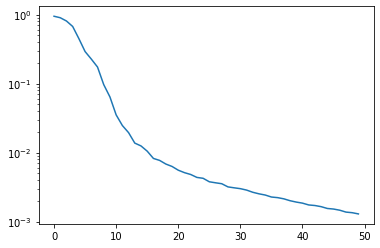

In [151]:
plt.plot(range(len(cost_list)),cost_list)
plt.yscale('log')

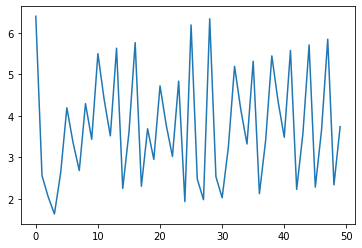

In [152]:
plt.plot(range(len(rate_list)),rate_list)

In [129]:
import torch
from torch.autograd import Variable
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit_machine_learning.connectors import TorchConnector
from torch.optim import Adam,SGD

In [130]:
def train_ADAM_pytorch(sampler,lr=1e-1,max_iter=100):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = Adam(sampler_torch.parameters(),lr=lr)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))

    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]

    for i in range(max_iter):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        print(cost)
        optimizer.step();
        if cost<1e-5:
            break

    return costList
    

In [137]:
t1=time.time()
cost_list_ADAMtorch_1en1=train_ADAM_pytorch(sampler,lr=1e-1,max_iter=50)
print(time.time()-t1)

0.9988185137417185
0.9546129965719332
0.86870619678334
0.7300521904409498
0.6187940614591696
0.5557385628570741
0.5171417291317159
0.47527161550870434
0.42324506305899956
0.37766777842277593
0.34745863244146
0.33342984927924263
0.3215757550145527
0.3026663552349369
0.2783002074194958
0.2545896047328187
0.23898403439704044
0.23058414341462974
0.2210061946658721
0.2063926846632319
0.19036010415642368
0.17730674000596566
0.1664185452275641
0.15351605879291
0.1378920292067866
0.1224039578160787
0.10936944596417547
0.0995974538349791
0.09267042201111769
0.0863448335708389
0.0786179864911543
0.06967014585780659
0.060916348379309995
0.05353850223251539
0.04744648026467201
0.04154366101897311
0.0359703255392144
0.0326709939352146
0.03229236742775
0.0321937715977471
0.029975681900553695
0.026953268468091297
0.025368842900438494
0.024845262472954797
0.023624142373634395
0.0212286339461548
0.018464793956659696
0.0160072100844748
0.014066516669992998
0.012624851668676797
34.30387496948242


In [138]:
t1=time.time()
cost_list_ADAMtorch_1e0=train_ADAM_pytorch(sampler,lr=1e0,max_iter=50)
print(time.time()-t1)

0.9461191352376142
0.9543179966646629
0.9679623740975756
0.9903085607242468
0.999322049262398
0.9815020728646152
0.9665676203941074
0.924556201239268
0.9865543189580698
0.9612586298300193
0.9419234054061495
0.8749743672667951
0.8254593696179563
0.8901574024760219
0.920816782473999
0.9067154282061709
0.8139958753374305
0.7072359506943064
0.7244892270178933
0.6570023478253368
0.600480339035917
0.5725524007600894
0.44964563128397567
0.4996877564756564
0.45310971182232035
0.4034184177469192
0.26878227062080867
0.3138617450323658
0.34299604441226234
0.24880792699619167
0.2543221514071503
0.20979852075075
0.1797931023959631
0.17879221459160957
0.18430781795847107
0.18500350943259208
0.13716343760584557
0.13701559229411453
0.10931799169336509
0.1117160374878417
0.13985726560620396
0.11844845130709226
0.07658690882377199
0.08521761693301899
0.08003903063840823
0.06735839559454698
0.0669132807398461
0.0624399624803037
0.049949898131643584
0.05166679477379858
34.3522732257843


In [139]:
def train_LBFGS_pytorch(sampler,lr=1e-1,max_iter=150):
    init = algorithm_globals.random.random(sampler.num_weights)
    sampler_torch = TorchConnector(sampler, initial_weights=init)
    optimizer = LBFGS(sampler_torch.parameters(),lr=lr, max_iter=max_iter)
    f_loss = CrossEntropyLoss()  
    X=Tensor(sampler_input)
    y=Tensor(np.array([1,0]))
    print(sampler.forward(sampler_input,init))
    
    # Start training
    sampler_torch.train()
    global costList
    costList=[]
    # Define LBFGS closure method (explained in previous section)
    def closure():
        global costList
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = f_loss(sampler_torch(X), y)  # Calculate loss
        loss.backward()  # Backward pass

        for param in sampler_torch.parameters():
            w=param.detach().numpy()
        cost=sampler.forward(sampler_input,w)[0][1]
        costList.append(cost)
        if(len(costList)%20==0):
            print(cost)

        return loss

    # Run optimizer (LBFGS requires closure)
    optimizer.step(closure);
        
    return costList
    

In [143]:
cost_list_LBFGStorch_1en1=[]
t1=time.time()
cost_list_LBFGStorch_1en1=train_LBFGS_pytorch(sampler,lr=1e-1,max_iter=200)
print(time.time()-t1)

[[0.00985502 0.99014498]]
0.9388886332447299
0.8581470984081744
0.23338144099316918
0.02964662549071619
0.008632687788880001
0.0031146573369789004
0.0010870527002674996
0.00036222699589839993
0.00014983777710729992
7.684961371619998e-05
135.67455101013184


In [141]:
cost_list_LBFGStorch_1e0=[]
t1=time.time()
cost_list_LBFGStorch_1e0=train_LBFGS_pytorch(sampler,lr=1e0,max_iter=100)
print(time.time()-t1)

[[0.02032175 0.97967825]]
0.6557789929018707
0.0061141636760428985
0.00019008442491049994
1.5542641052799997e-05
63.49890875816345


<Figure size 432x288 with 0 Axes>

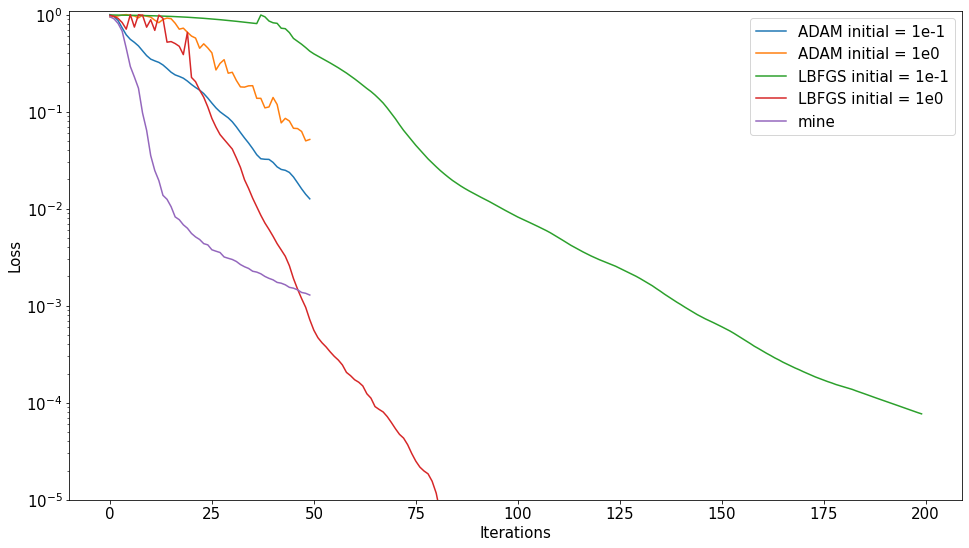

In [153]:
LabelSize=15
plt.figure(1)
plt.figure(figsize=(16,9))
plt.yscale('log')
plt.ylim(1e-5,1.1)

plt.plot(range(len(cost_list_ADAMtorch_1en1)),cost_list_ADAMtorch_1en1,label='ADAM initial = 1e-1')
plt.plot(range(len(cost_list_ADAMtorch_1e0)),cost_list_ADAMtorch_1e0,label='ADAM initial = 1e0')

plt.plot(range(len(cost_list_LBFGStorch_1en1)),cost_list_LBFGStorch_1en1,label='LBFGS initial = 1e-1')
plt.plot(range(len(cost_list_LBFGStorch_1e0)),cost_list_LBFGStorch_1e0,label='LBFGS initial = 1e0')

plt.plot(range(len(cost_list)),cost_list,label='mine')
plt.yscale('log')

plt.xlabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)